## Pregunta 1: Entrenamiento de RNNs en una Serie de Tiempo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from timeit import default_timer as timer
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


*   **Parte a)**



Cargamos los datos, hacemos la división entre sets de entrenamiento y prueba, y realizamos el escalado correspondiente para trabajar con redes neuronales recurrentes.

In [0]:
name_f = "https://github.com/csaldias/tarea2-RedesNeuronales/raw/master/time_series_data.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)[:2000]
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test = dataframe[:1500].values, dataframe[1500:].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

*   **Parte b)**

Ahora definimos la función que nos permitirá realizar las predicciones de temperatura utilizando RNN's. La función toma el dataset que creamos en el punto anterior y crea 2 arreglos, dataX y dataY, en donde los datos se encuentran organizados de acuerdo a lo especificado en el enunciado, esto es, para predecir el valor futuro se utiliza una cantidad determinada de valores, incluído el valor actual (cantidad que aquí llamos *lag*).

In [0]:
def create_dataset(dataset,lag=1):
    dataX = []
    dataY = []
    for index in range(len(dataset)-lag):
        dataX.append(dataset[index:index+lag])
        dataY.append(dataset[index+lag])
    return np.array(dataX),np.array(dataY)

*   **Parte c)**

Utilizando la función que creamos en el punto anterior, generamos los conjuntos de entrenamiento y pruebas.

In [0]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

*   **Parte d)**

Dado que actualmente nuestros datos están en la forma [ejemplos, atributos], y que la red LSTM necesita que los datos se encuentren en un arreglo de tres dimensiones de la forma [samples, time steps, features], debemos tranformar nuestros conjuntos de entrenamiento y pruebas a la estructura deseada.

In [0]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

*   **Parte e)**

Ahora que tenemos todos los datasets en el formato adecuado, realizamos el entrenamiento de la red LSTM.

In [8]:
model = Sequential()
model.add(LSTM(4, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
inicio = timer()
hist = model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=2)
end = timer()

Epoch 1/25
 - 10s - loss: 0.0210
Epoch 2/25
 - 10s - loss: 0.0104
Epoch 3/25
 - 10s - loss: 0.0102
Epoch 4/25
 - 10s - loss: 0.0102
Epoch 5/25
 - 10s - loss: 0.0102
Epoch 6/25
 - 10s - loss: 0.0102
Epoch 7/25
 - 10s - loss: 0.0102
Epoch 8/25
 - 10s - loss: 0.0102
Epoch 9/25
 - 10s - loss: 0.0102
Epoch 10/25
 - 10s - loss: 0.0101
Epoch 11/25
 - 10s - loss: 0.0101
Epoch 12/25
 - 10s - loss: 0.0101
Epoch 13/25
 - 10s - loss: 0.0101
Epoch 14/25
 - 10s - loss: 0.0101
Epoch 15/25
 - 10s - loss: 0.0101
Epoch 16/25
 - 10s - loss: 0.0101
Epoch 17/25
 - 10s - loss: 0.0101
Epoch 18/25
 - 10s - loss: 0.0101
Epoch 19/25
 - 10s - loss: 0.0102
Epoch 20/25
 - 10s - loss: 0.0101
Epoch 21/25
 - 10s - loss: 0.0101
Epoch 22/25
 - 10s - loss: 0.0101
Epoch 23/25
 - 10s - loss: 0.0101
Epoch 24/25
 - 10s - loss: 0.0100
Epoch 25/25
 - 10s - loss: 0.0101


In [9]:
print("Tiempo de Ejecucion: {:.3f} min".format( (end - inicio)/60) )

Tiempo de Ejecucion: 4.195 min


*   **Parte f)**

Ahora hacemos las predicciones del modelo para los conjuntos de entrenamiento y prueba, además de denormalizar los datos para poder calcular el error en la escala original de los datos.

In [0]:
trainPredict = model.predict(trainX,batch_size=1)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

In [0]:
testPredict = model.predict(testX,batch_size=1)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

*   **Parte g)**

A continuación, obtenemos el Root Mean Squared Error (o RMSE) para las predicciones de los conjuntos de entrenamiento y prueba.

In [12]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.62 RMSE
Test Score: 2.41 RMSE


Los valores obtenidos para el RMSE en ambos conjuntos son bastante bajos, y nos dicen que el valor predecido por la red está a +/- 2.65 grados del valor "real" del conjunto de entrenamiento, y a +/- 2.45 grados del valor "real" del conjunto de pruebas, lo que podemos considerar como una predicción bastante buena, considerando que se está trabajando con datos meteorológicos que de por sí tienen una cierta aleatoridad asociada.

*   **Parte h)**

Antes de graficar las temperaturas originales y las predictas por la red, debemos desplazar las predicciones en el eje X para que coincidan con las temperaturas originales, y así poder observar las diferencias entre ambas curvas.

In [0]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[0:len(trainPredict)-1, :] = trainPredict[1:]
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[0:len(testPredict)-1, :] = testPredict[1:]

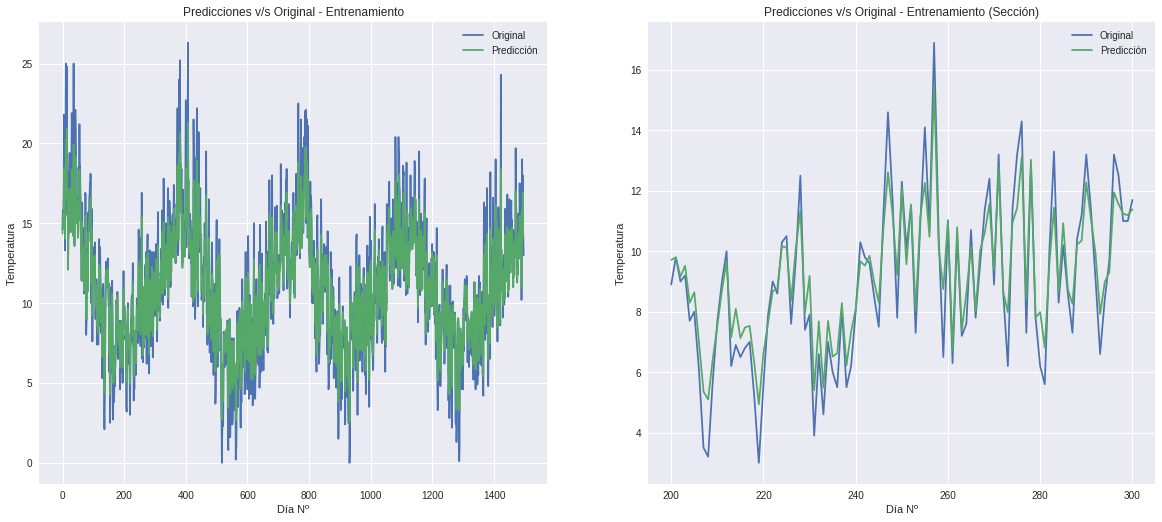

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))

ax1.plot(range(len(trainY)), trainY, trainPredictPlot)
ax1.set_title("Predicciones v/s Original - Entrenamiento")
ax1.legend(['Original', 'Predicción'], loc='upper right')
ax1.set_ylabel('Temperatura')
ax1.set_xlabel('Día Nº')

ax2.plot(range(200,301), trainY[200:301])
ax2.plot(range(200,301), trainPredictPlot[200:301])
ax2.set_title("Predicciones v/s Original - Entrenamiento (Sección)")
ax2.legend(['Original', 'Predicción'], loc='upper right')
ax2.set_ylabel('Temperatura')
ax2.set_xlabel('Día Nº')

plt.show()

Como se puede observar, la curva obtenida en base a las predicciones de la red durante el entrenamiento es increíblemente similar a la curva original, siendo la curva de la predicción más suave en sus variaciones en comparación a la curva original. Esto no es un gran problema en la práctica, dado que estas diferencias entre lo predicho y lo acontecido pueden ser fácilmente atribuíbles a los errores de medición propios de los sensores meteorológicos o a factores imprevistos de este último.

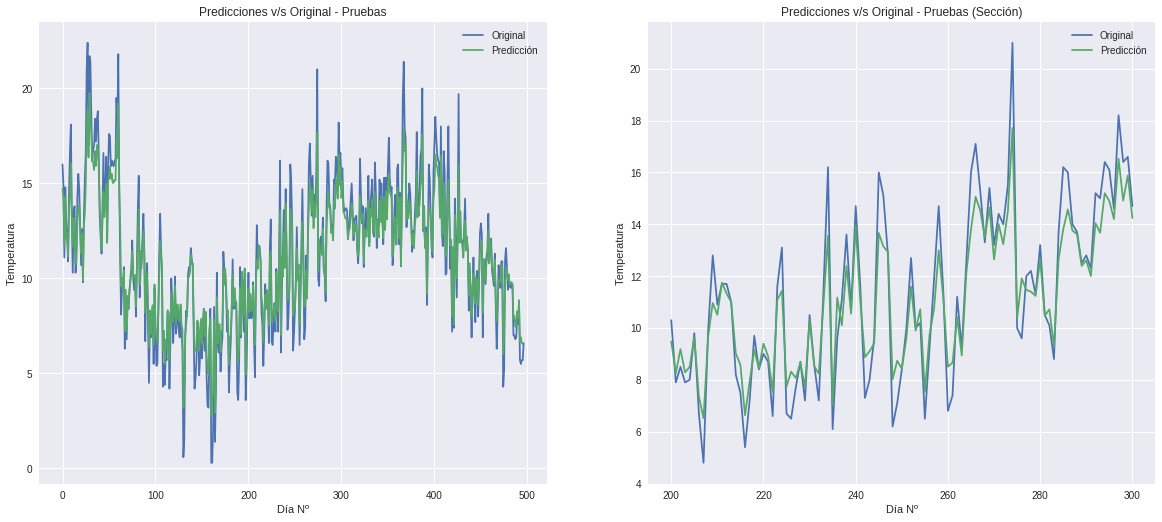

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))

ax1.plot(range(len(testY)), testY, testPredictPlot)
ax1.set_title("Predicciones v/s Original - Pruebas")
ax1.legend(['Original', 'Predicción'], loc='upper right')
ax1.set_ylabel('Temperatura')
ax1.set_xlabel('Día Nº')

ax2.plot(range(200,301), testY[200:301])
ax2.plot(range(200,301), testPredictPlot[200:301])
ax2.set_title("Predicciones v/s Original - Pruebas (Sección)")
ax2.legend(['Original', 'Predicción'], loc='upper right')
ax2.set_ylabel('Temperatura')
ax2.set_xlabel('Día Nº')

plt.show()

Tal como en el caso de la curva de entrenamiento, la curva producto de las predicciones de la red obtenidas del set de prueba es increíblemetne similar a la curva original, mostrando sólo algunas diferencias en las variaciones de temperatura a lo largo del eje temporal. Estos gráficos nos permiten apreciar de mejor forma la medida cuantitativa de error RMSE que calculamos en el punto anterior, y a concluir que la red efectivamente realiza predicciones adecuadas en base a los datos de entrenamiento y de pruebas.

*   **Parte i)**

Ahora, en lugar de aumentar el número de dimensiones (como lo que realizamos en el punto e), entrenamos la red con un timestep de 3, esto es, con dimensión de entrada 1:

In [17]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

model = Sequential()
#input_shape pasa de ser (None, lag) a ser (None, 1), es decir, una dimensión de entrada 1
model.add(LSTM(4, input_shape=(None, 1), activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

inicio_i = timer()
hist = model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=2)
fin_i = timer()

Epoch 1/25
 - 15s - loss: 0.0218
Epoch 2/25
 - 14s - loss: 0.0122
Epoch 3/25
 - 14s - loss: 0.0117
Epoch 4/25
 - 14s - loss: 0.0115
Epoch 5/25
 - 14s - loss: 0.0113
Epoch 6/25
 - 14s - loss: 0.0111
Epoch 7/25
 - 14s - loss: 0.0110
Epoch 8/25
 - 14s - loss: 0.0109
Epoch 9/25
 - 14s - loss: 0.0108
Epoch 10/25
 - 14s - loss: 0.0106
Epoch 11/25
 - 14s - loss: 0.0106
Epoch 12/25
 - 14s - loss: 0.0105
Epoch 13/25
 - 14s - loss: 0.0106
Epoch 14/25
 - 14s - loss: 0.0104
Epoch 15/25
 - 14s - loss: 0.0105
Epoch 16/25
 - 14s - loss: 0.0105
Epoch 17/25
 - 14s - loss: 0.0104
Epoch 18/25
 - 14s - loss: 0.0104
Epoch 19/25
 - 14s - loss: 0.0104
Epoch 20/25
 - 14s - loss: 0.0104
Epoch 21/25
 - 14s - loss: 0.0104
Epoch 22/25
 - 14s - loss: 0.0103
Epoch 23/25
 - 14s - loss: 0.0103
Epoch 24/25
 - 14s - loss: 0.0103
Epoch 25/25
 - 14s - loss: 0.0102


Ahora, realizamos las predicciones para calcular los errores de predicción y pruebas:

In [0]:
trainPredict = model.predict(trainX,batch_size=1)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

In [0]:
testPredict = model.predict(testX,batch_size=1)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [20]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.42 RMSE


Como podemos observar, la diferencia entre los errores de entrenamiento y de prueba para el punto i) son marginalmente mayores a los errores para el punto e) (2.62 y 2.41 para entrenamiento y prueba, respectivamente), siendo los errores del punto e) los menores. Notar que, para el caso del error de prueba, el error es el mismo para ambos puntos. Esto nos lleva a decir que la dimensionalidad de la entrada no sería un factor relevante a la hora de analizar el desempeño de una red en esta aplicación, aunque esto es sin considerar el tiempo de ejecución.

In [21]:
print("Tiempo de Ejecucion e): {:.3f} min".format( (end - inicio)/60) )
print("Tiempo de Ejecucion i): {:.3f} min".format( (fin_i - inicio_i)/60) )

Tiempo de Ejecucion e): 4.195 min
Tiempo de Ejecucion i): 5.885 min


Al observar los tiempos de ejecución de ambos métodos, es claro que el método con una dimensionalidad mayor es más rápido que el método con una dimensión de 1, aunque ambos métodos tienen prácticamente el mismo error de entrenamiento y de prueba.

A manera de comprobar cómo queda la curva de temperaturas predichas en comparación a los valores originales, el gráfico de la curva de entrenamiento del punto h) con la red obtenida en este punto:

In [0]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[0:len(trainPredict)-1, :] = trainPredict[1:]
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[0:len(testPredict)-1, :] = testPredict[1:]

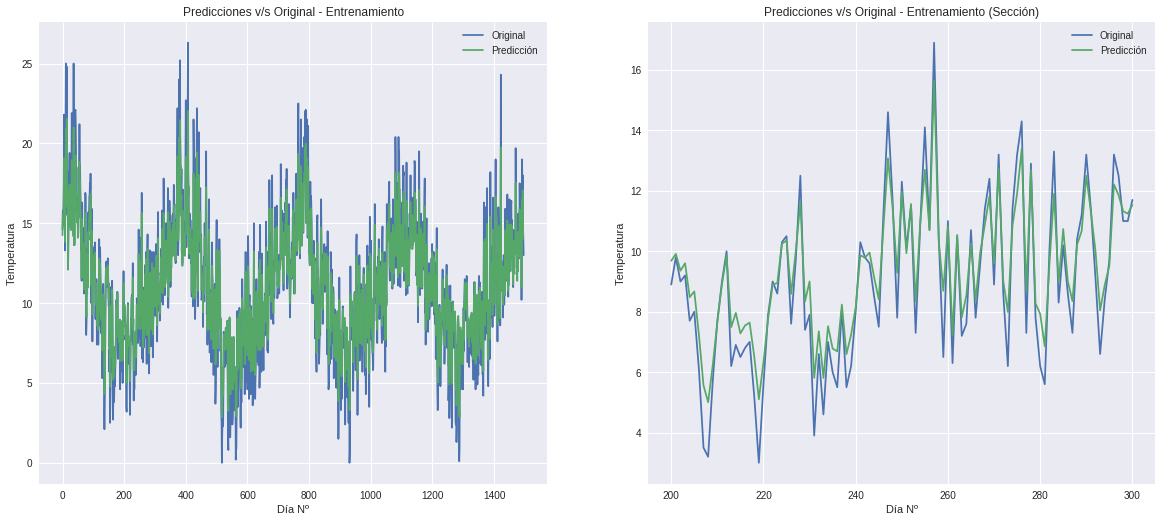

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))

ax1.plot(range(len(trainY)), trainY, trainPredictPlot)
ax1.set_title("Predicciones v/s Original - Entrenamiento")
ax1.legend(['Original', 'Predicción'], loc='upper right')
ax1.set_ylabel('Temperatura')
ax1.set_xlabel('Día Nº')

ax2.plot(range(200,301), trainY[200:301])
ax2.plot(range(200,301), trainPredictPlot[200:301])
ax2.set_title("Predicciones v/s Original - Entrenamiento (Sección)")
ax2.legend(['Original', 'Predicción'], loc='upper right')
ax2.set_ylabel('Temperatura')
ax2.set_xlabel('Día Nº')

plt.show()

Tal como se observó en el punto h), las curvas de temperaturas originales y predichas son increíblemente similares entre sí, sólo presentando algunas variaciones en la magnitud de las variaciones de temperaturas entre días, esto es, la curva de valores predichos es generalmente más "suave" en sus variaciones que la curva de valores originales.

A simple vista, comparando los gráficos de ambos puntos, es muy difícil discernir entre qué forma es mejor, sobre todo considerando que el error obtenido por parte de ambas redes es increíblemente similar (por no decir iguales). El único criterio, entonces, que tenemos para discernir entre qué red es mejor es el tiempo de ejecución de las mismas, donde la red del punto e) resulta ser la ganadora por casi 2 minutos de ventaja. Esto tiene sentido, ya que la red del punto e) cuenta con una mayor cantidad de información temporal para realizar las predicciones, pudiendo de esta forma alcanzar convergencia en un tiempo menor al de la red de este punto.

> **Parte j)**

Ahora, determinaremos el parámetro del número de bloques para la red LSTM de la pregunta e). Dado que utilizar 5-fold cross validation nos podría tomar un tiempo considerable, como hemos aprendido de la tarea anterior, utilizaremos la porción del dataser que no ha sido utilizada ni como entrenamiento ni como pruebas (esto es, desde el índice 2000 hacia adelante) como conjunto fijo de validación.

Primero, debemos obtener nuestros conjuntos de entrenamiento, pruebas y validación desde el dataset.

In [0]:
name_f = "https://github.com/csaldias/tarea2-RedesNeuronales/raw/master/time_series_data.csv"

dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test, df_validation = dataframe[:1500].values, dataframe[1500:2000].values, dataframe[2000:].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)
stream_validation_scaled = scaler.transform(df_validation)

Ahora, creamos los conjuntos de entrenamiento, validación y pruebas, y entrenamos la red del punto e) variando valor de units de la capa LSTM entre 4 y 12, guardando los resultados de tiempo, error RMSE y valores de pérdida por cada epoch de la red.

In [7]:
lag = 3
resultados = {}

for unit in range(4, 13, 2):
    trainX, trainY = create_dataset(stream_train_scaled, lag)
    testX, testY = create_dataset(stream_test_scaled, lag)
    validationX, validationY = create_dataset(stream_validation_scaled, lag)
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    validationX = np.reshape(validationX, (validationX.shape[0], 1, validationX.shape[1]))
    
    print("Usando unit={}...".format(unit))
    model = Sequential()
    model.add(LSTM(units=unit, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    inicio = timer()
    hist = model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=0, validation_data=(testX, testY))
    end = timer()
    
    valPredict = model.predict(validationX,batch_size=1)
    valPredict = scaler.inverse_transform(valPredict)
    validationY = scaler.inverse_transform(validationY)
    valScore = math.sqrt(mean_squared_error(validationY, valPredict))
    
    resultados[unit] = ((end-inicio), valScore, hist.history["loss"])
    
    #print("Tiempo para unit={}: {:.3f} min".format(unit, (end-inicio)/60 ))
    #print("Score para unit={}: Error={:.2f} RMSE".format(unit, valScore))

Usando unit=4...
Usando unit=6...
Usando unit=8...
Usando unit=10...
Usando unit=12...


Ahora, analicemos los resultados:

In [8]:
print("Unit\tTiempo [min]\tError [RMSE]")
for unit in resultados:
    print("{}\t{:.4f}\t\t{:.4f}".format(unit, resultados[unit][0]/60, resultados[unit][1]))

Unit	Tiempo [min]	Error [RMSE]
4	4.6407		2.4498
6	4.6681		2.4543
8	4.6630		2.5142
10	4.6672		2.4524
12	4.6952		2.5888


A juzgar por los valores de error para cada una de los posibles valores para las unidades de la capa LSTM de la red, la mejor opción es utilizar un valor de unit de 4 en dicha capa, dado que es la que posee el menor error RMSE asociado y el menor tiempo de ejecución. Valores más altos para el unit de esta capa resultan en errores RMSE marginalmente más grandes, siendo el error más alto alcanzado con un valor de unidad igual a 12. También es importante mencionar que la diferencia entre los errores y tiempos de ejecución para 6 y 10 unidades es bastante reducida, por lo que podríamos pensar que ambas opciones producirán un resultado similar, aún cuando la opción de 10 unidades es ligeramente más lenta que 4 unidades.

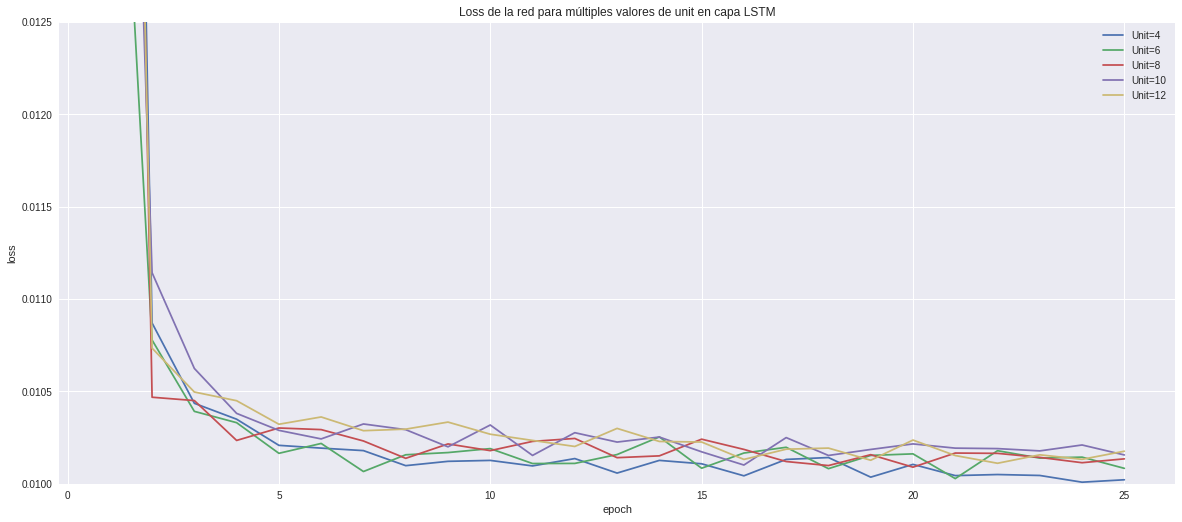

In [11]:
legend = []
plt.figure(figsize=(20,8.5))
for unit, (_, _, loss) in list(resultados.items()):
    plt.plot(range(1, 26), loss)
    legend.append("Unit="+str(unit))

#plt.ylim(ymax=ymax, ymin=0)
plt.title("Loss de la red para múltiples valores de unit en capa LSTM")
plt.legend(legend, loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(ymax=0.01250, ymin=0.010)

plt.show()

Es importante notar que, aún cuando el error RMSE muestra notorias diferencias entre distintos valores para el unit del LSTM, las curvas de loss por epoch para cada uno de los valores de unit son bastante similares hasta cierto punto. Podríamos decir que la curva de unit=4 corresponde a la más estable de las presentadas, pero esta conclusión es difícil de hacer únicamente en base a los datos que se aprecian en el gráfico, siendo necesario recurrir al error RMSE para realizar una conclusión adecuada de este experimento, además de estar utilizando la misma forma de medir el desempeño de la red que se ha utilizado a lo largo de esta pregunta.

> **Parte k)**

A continuación, analizaremos el desempeño de la red para distintos valores de lag, esto es, la cantidad de información que se está utilizando para realizar cada predicción.

In [0]:
name_f = "https://github.com/csaldias/tarea2-RedesNeuronales/raw/master/time_series_data.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)[:2000]
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test = dataframe[:1500].values, dataframe[1500:].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

In [26]:
resultados = {}
for lag in range(1, 5, 1):
    trainX, trainY = create_dataset(stream_train_scaled, lag)
    testX, testY = create_dataset(stream_test_scaled, lag)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    print("Usando lag={}...".format(lag))
    model = Sequential()
    model.add(LSTM(units=4, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    inicio = timer()
    hist = model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=0)
    end = timer()
    
    trainPredict = model.predict(trainX,batch_size=1)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    
    testPredict = model.predict(testX,batch_size=1)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    
    resultados[lag] = ((end-inicio), trainScore, testScore, hist.history["loss"], hist.history["acc"])
    
    #print("Tiempo para unit={}: {:.3f} min".format(unit, (end-inicio)/60 ))
    #print("Score para unit={}: Error={:.2f} RMSE".format(unit, valScore))

Usando lag=1...
Usando lag=2...
Usando lag=3...
Usando lag=4...


In [27]:
print("Lag\tTiempo [min]\tTrain Score[RMSE]\tTest Score [RMSE]")
for lag in resultados:
    print("{}\t{:.4f}\t\t{:.2f}\t\t\t{:.2f}".format(lag, resultados[lag][0]/60, resultados[lag][1], resultados[lag][2]))

Lag	Tiempo [min]	Train Score[RMSE]	Test Score [RMSE]
1	4.4321		2.68			2.47
2	4.4323		2.71			2.50
3	4.4374		2.66			2.46
4	4.4688		2.59			2.38


Del experimento realizado, se puede observar un resultado que podría ser bastante obvio o lógico: a mayor información disponible para realizar la predicción (esto es, a mayor lag utilizado), menor el error RMSE asociado, tanto en entrenamiento como en prueba. Teniendo en cuenta que una mayor cantidad de datos es casi siempre mejor, debido a que ayuda a evitar el overfitting en la red, una mayor cantidad de datos para realizar la predicción es preferible en este caso, siendo esto evidenciado en el hecho de que los errores RMSE de entrenamiento y prueba más bajos se dan con el valor de lag más alto, esto es, con la mayor cantidad de datos para realizar las predicciones.

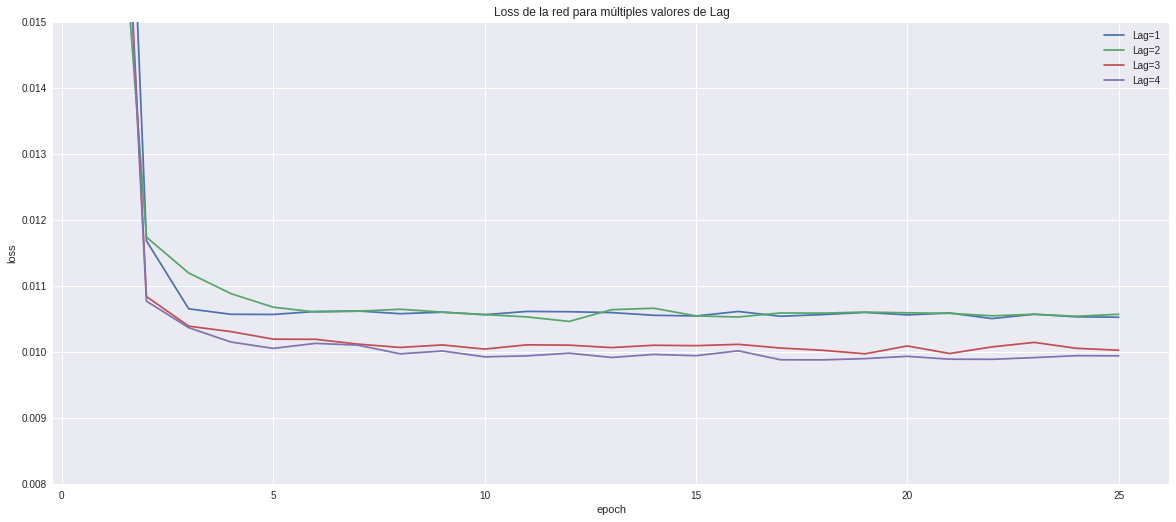

In [29]:
legend = []
plt.figure(figsize=(20,8.5))
for lag, (_, _, _, loss, _) in list(resultados.items()):
    plt.plot(range(1, 26), loss)
    legend.append("Lag="+str(lag))

#plt.ylim(ymax=ymax, ymin=0)
plt.title("Loss de la red para múltiples valores de Lag")
plt.legend(legend, loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(ymax=0.015, ymin=0.008)

plt.show()

Tal como en el punto anterior, la información que entrega el gráfico de pérdida por epoch para cada valor de Lag en estudio no es suficiente para brindar una conclusión clara por sí sola, sino que se debe complementar con la información de error RMSE por cada lag. En efecto, esta última información se condice con lo que muestra este gráfico, en donde un aumento de la cantidad de datos utilizados para realizar las predicciones (un aumento del lag) lleva a tener pérdidas más bajas en la red, siendo la red con las pérdidas bás bajas la que utiliza un Lag igual a 4.

> **Parte l)**

A contiuación compararemos el desempeño de la LSTM con una red recurrente simple y una GRU, utilizando para todas un lag de 3.

In [18]:
#convergencia y el tiempo de ejecución
resultados = {}
lag = 3

for tipo in range(3):
    print("Usando tipo", tipo, "...")
    
    trainX, trainY = create_dataset(stream_train_scaled, lag)
    testX, testY = create_dataset(stream_test_scaled, lag)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    model = Sequential()
    if tipo == 0: #LSTM
        model.add(LSTM(4, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
    elif tipo == 1: #GRU
        model.add(GRU(4, input_shape=(None, lag), activation='tanh', recurrent_initializer='orthogonal'))
    elif tipo == 2: #SimpleRNN
        model.add(SimpleRNN(4, input_shape=(None, lag), activation='tanh', recurrent_initializer='orthogonal'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    inicio = timer()
    hist = model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=0)
    end = timer()

    trainPredict = model.predict(trainX,batch_size=1)
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(trainY)
    
    testPredict = model.predict(testX,batch_size=1)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(testY)
    
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    
    resultados[tipo] = ((end-inicio), trainScore, testScore, hist.history["loss"], hist.history["acc"])

Usando tipo 0 ...
Usando tipo 1 ...
Usando tipo 2 ...


In [19]:
print("Tipo\t\tTiempo [min]\tTrain Score [RMSE]\tTest Score [RMSE]")
for tipo in resultados:
    if tipo == 0:
        tipo_texto = "LSTM     "
    elif tipo == 1:
        tipo_texto = "GRU      "
    elif tipo == 2:
        tipo_texto = "SimpleRNN"
    print("{}\t{:.4f}\t\t{:.2f}\t\t\t{:.2f}".format(tipo_texto, resultados[tipo][0]/60, resultados[tipo][1], resultados[tipo][2]))

Tipo		Tiempo [min]	Train Score [RMSE]	Test Score [RMSE]
LSTM     	4.4138		2.72			2.53
GRU      	4.3996		2.63			2.43
SimpleRNN	3.3985		2.62			2.42


De los resultados obtenidos, se puede concluir que la red con el mejor desempeño sobre los datos es la SimpleRNN, cuyos errores son los menores de las 3 redes en estudio, y además es la red que menos tiempo toma en ejecutarse durante el entrenamiento. Esto deja en evidenica la diferencia entre las complejidades (y el consecuente costo computacional) de cada una de las redes estudiadas, la que se ve reflejada en la diferencia entre los tiempos de ejecución de cada una de las redes en estudio, siendo la red LSTM la más compleja de todas.

Es necesario notar que la diferencia entre los errores RMSE de las redes en estudio no supera las 0.11 unidades, lo que nos dice que el desempeño de estas redes bajo el caso de uso que estamos estudiando es bastante similar, y que podríamos utilizar alguna de las otras 2 redes analizadas para obtener resultados más rápidamente si es que resulta necesario.

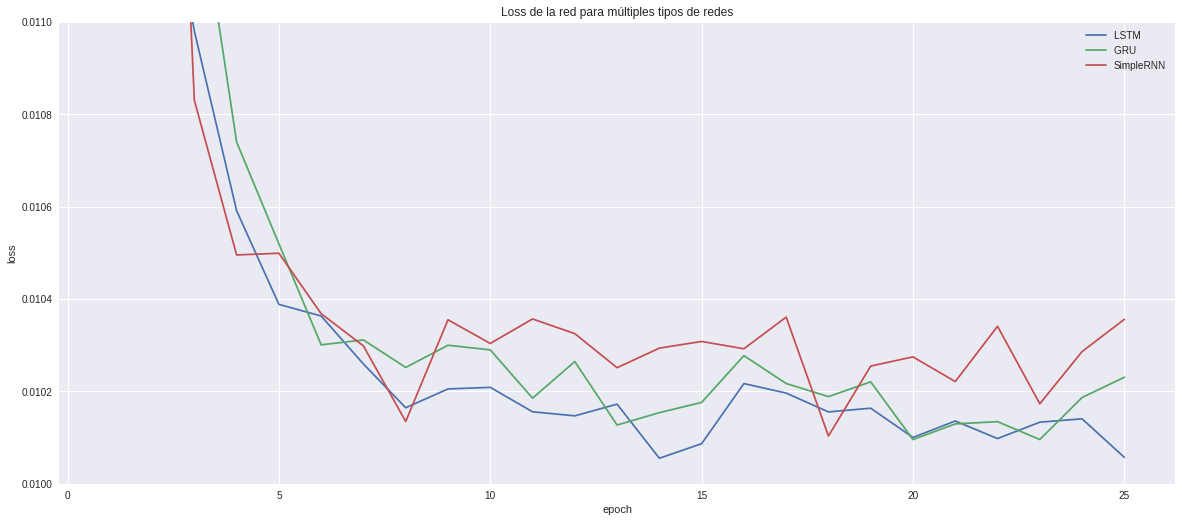

In [23]:
legend = []
plt.figure(figsize=(20,8.5))
for tipo, (_, _, _, loss, _) in list(resultados.items()):
    if tipo == 0:
        tipo_texto = "LSTM     "
    elif tipo == 1:
        tipo_texto = "GRU      "
    elif tipo == 2:
        tipo_texto = "SimpleRNN"
    plt.plot(range(1, 26), loss)
    legend.append(tipo_texto)

#plt.ylim(ymax=ymax, ymin=0)
plt.title("Loss de la red para múltiples tipos de redes")
plt.legend(legend, loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(ymax=0.011, ymin=0.01)

plt.show()

Del gráfico de pérdida de las redes en estudio en función del epoch, podemos notar que la convergencia de las redes es, a simple vista, bastante similar, teniendo en consideración los acotados límites del eje Y de este gráfico utilizados para poder apreciar las sutiles diferencias entre cada una de las redes. Se puede observar que la red LSTM es la red que obtiene los valores de pérdida más bajos de entre las redes en estudio, lo que no se condice con la conclusión obtenida anteriormente, y nos indica que el gráfico de pérdidas de las redes en estudio en función de los epochs no nos informa adecuadamente del desempeño real de cada una de las redes.

> **Parte m)**

A continuación, entrenaremos la red LSTM del punto e) utilizando memoria entre batches.

Es necesario notar que la red LSTM de este punto espera que la dimensionalidad de los datos sea de (1, 3), mientras que la dimensionalidad de los datos luego de los pasos c) y d) es de (3, 1). La no realización del paso d) deja los datos en la dimensión esperada por esta red, pudiendo así proceder con el entrenamiento de la misma.

In [28]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

#La red LSTM de este
batch_size = 1
model = Sequential()
# Expected input batch shape: (batch_size, timesteps, data_dim)
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
inicio = timer()
for i in range(25):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()
end = timer()

Epoch 1/1
1497/1497 [==============================] - 19s 13ms/step - loss: 0.0142
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0107
Epoch 1/1
 446/1497 [=======>......................] - ETA: 12s - loss: 0.0108

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0105
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0104
Epoch 1/1
 722/1497 [=============>................] - ETA: 9s - loss: 0.0107

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0101
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0099
Epoch 1/1
 826/1497 [===============>..............] - ETA: 7s - loss: 0.0102

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0097
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0095
Epoch 1/1
 829/1497 [===============>..............] - ETA: 8s - loss: 0.0099

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
 827/1497 [===============>..............] - ETA: 8s - loss: 0.0098

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
 872/1497 [================>.............] - ETA: 7s - loss: 0.0097

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
 845/1497 [===============>..............] - ETA: 7s - loss: 0.0098

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
 815/1497 [===============>..............] - ETA: 8s - loss: 0.0097

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
 837/1497 [===============>..............] - ETA: 7s - loss: 0.0099

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
 814/1497 [===============>..............] - ETA: 8s - loss: 0.0097

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
 828/1497 [===============>..............] - ETA: 8s - loss: 0.0099

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0094
Epoch 1/1
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0095
Epoch 1/1
 817/1497 [===============>..............] - ETA: 8s - loss: 0.0098

1497/1497 [==============================] - 18s 12ms/step - loss: 0.0095


In [29]:
trainPredict = model.predict(trainX,batch_size=1)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

testPredict = model.predict(testX,batch_size=1)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))
print('Tiempo de Ejecución: %.4f Min.' % ((end - inicio)/60))

Train Score: 3.14 RMSE
Test Score: 2.92 RMSE
Tiempo de Ejecución: 7.5856 Min.


Dado que hemos utilizado los errores RMSE de entrenamiento y pruebas para medir y comparar todas las redes estudiadas hasta el momento, tiene sentido que también utilicemos esta métrica para medir el desempeño de esta red. De inmediato se puede observar que el desempeño de la red LSTM c/memoria entre batches no es superior al desempeño de ninguna de las otras redes estudiadas en el punto anterior, siendo esta la red estudiada con el peor desempeño hasta el momento. Esto, sumado al hecho de que el tiempo de ejecución de la red LSTM c/ memoria entre batches es más de 3 minutos más lento que la red más lenta estudiada previamente, nos permite concluir que el uso de esta red no mejora la predicción de las temperaturas.

In [0]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[0:len(trainPredict)-1, :] = trainPredict[1:]
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[0:len(testPredict)-1, :] = testPredict[1:]

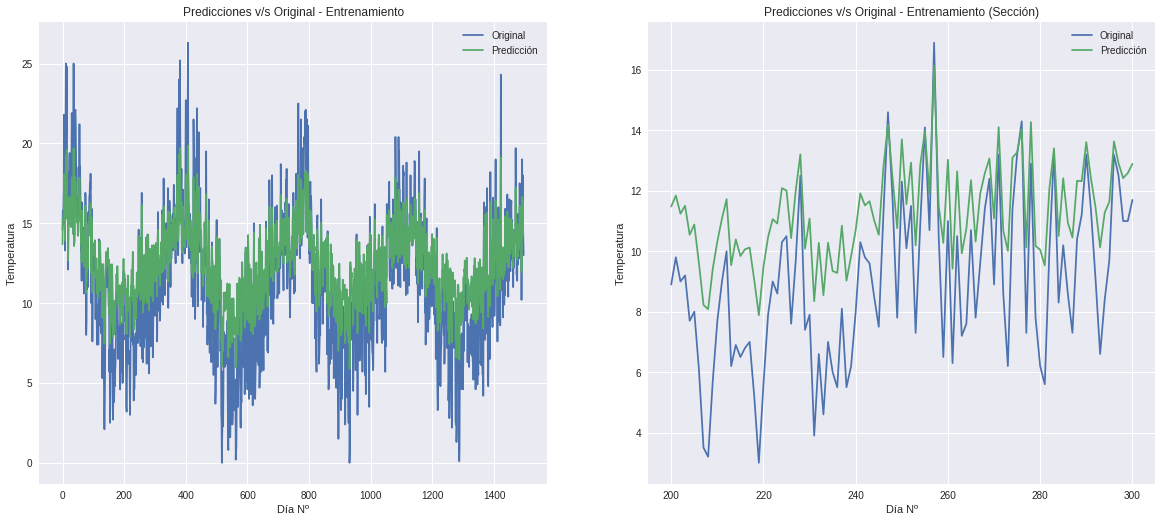

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))

ax1.plot(range(len(trainY)), trainY, trainPredictPlot)
ax1.set_title("Predicciones v/s Original - Entrenamiento")
ax1.legend(['Original', 'Predicción'], loc='upper right')
ax1.set_ylabel('Temperatura')
ax1.set_xlabel('Día Nº')

ax2.plot(range(200,301), trainY[200:301])
ax2.plot(range(200,301), trainPredictPlot[200:301])
ax2.set_title("Predicciones v/s Original - Entrenamiento (Sección)")
ax2.legend(['Original', 'Predicción'], loc='upper right')
ax2.set_ylabel('Temperatura')
ax2.set_xlabel('Día Nº')

plt.show()

La conclusión obtenida anteriormente queda confirmada por lo que se puede ver al graficar la predicción realizada por la red, y compararla con los datos originales de temperatura. Se puede observar que ambas curvas presentan diferencias que son más notorias que las presentadas por la red del punto e) (y cuyas predicciones fueron graficadas en el punto h), siendo las temperaturas predichas consistentemente más altas que las temperaturas reales. Lo anterior dista mucho de lo presentado en el punto h), en donde la curva de temperaturas predichas guardaba una cercana similitud a la curva de temperaturas originales, por lo que se puede volver a afirmar que el uso de la red LSTM c/memoria entre batches, al menos en su configuración actual, no representa una mejora en la predicción de tempraturas.

> **Parte n)**

Basados en las conclusiones anteriores, examinaremos si la variación del tamaño del batch es capaz de mejorar el desempeño observado previamente. Para esto, variaremos el valor del tamaño del batch para posteriormente comentar los resultados obtenidos. Sin embargo, esto representa un problema.

In [52]:
print("El conjunto de entrenamiento tiene {} elementos.".format(trainX.shape[0]))
print("El conjunto de pruebas tiene {} elementos.".format(testX.shape[0]))

El conjunto de entrenamiento tiene 1497 elementos.
El conjunto de pruebas tiene 497 elementos.


En una red LSTM c/ memoria entre batches, el tamaño del batch especificado debe ser un divisor de la cantidad de elementos del conjunto utilizado para realizar el entrenamiento. Dado que el conjunto de entrenamiento posee 1497 elementos, el tamaño del batch utilizado debe ser un divisor de este número, lo que limita en gran medida nuestras opciones.

In [39]:
from functools import reduce

def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(pow(n, 0.5) + 1)) if n % i == 0)))

print(factors(1497))

{1, 3, 1497, 499}


De la misma forma, el tamaño del batch especificado debe, además, ser un divisor del número de elementos del conjunto de evaluación (497 elementos), de otra forma la evaluación arrojará error:

In [48]:
print(factors(497))

{1, 497, 71, 7}


El tamaño del batch, entonces, debe ser aquel número que forme parte de los divisores tanto de la cantidad de elementos del conjunto de validación como de prueba. En este caso, sólo el número 1 es divisor de ambas cifras, por lo que es el único tamaño factible para el batch utilizable en estas circunstancias, valor que ya fue utilizado en el punto anterior.

> **Parte o)**

A continuación construiremos una LSTM apilada, y la compararemos con los resultados obtenidos en el punto en i).

In [67]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

model = Sequential()
#input_shape pasa de ser (None, lag) a ser (None, 1), es decir, una dimensión de entrada 1
model.add(LSTM(4, input_shape=(None, 1), return_sequences=True))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

inicio_i = timer()
hist = model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=2)
fin_i = timer()

Epoch 1/25
 - 35s - loss: 0.0183
Epoch 2/25
 - 32s - loss: 0.0131
Epoch 3/25
 - 32s - loss: 0.0129
Epoch 4/25
 - 32s - loss: 0.0125
Epoch 5/25
 - 32s - loss: 0.0117
Epoch 6/25
 - 32s - loss: 0.0111
Epoch 7/25
 - 32s - loss: 0.0106
Epoch 8/25
 - 32s - loss: 0.0105
Epoch 9/25
 - 32s - loss: 0.0104
Epoch 10/25
 - 32s - loss: 0.0103
Epoch 11/25
 - 32s - loss: 0.0105
Epoch 12/25
 - 32s - loss: 0.0103
Epoch 13/25
 - 32s - loss: 0.0102
Epoch 14/25
 - 32s - loss: 0.0104
Epoch 15/25
 - 32s - loss: 0.0103
Epoch 16/25
 - 32s - loss: 0.0102
Epoch 17/25
 - 32s - loss: 0.0103
Epoch 18/25
 - 32s - loss: 0.0102
Epoch 19/25
 - 32s - loss: 0.0102
Epoch 20/25
 - 32s - loss: 0.0101
Epoch 21/25
 - 32s - loss: 0.0102
Epoch 22/25
 - 32s - loss: 0.0100
Epoch 23/25
 - 32s - loss: 0.0102
Epoch 24/25
 - 32s - loss: 0.0102
Epoch 25/25
 - 32s - loss: 0.0100


In [68]:
trainPredict = model.predict(trainX,batch_size=1)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

testPredict = model.predict(testX,batch_size=1)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
testScore = math.sqrt(mean_squared_error(testY, testPredict))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))
print('Tiempo de Ejecución: %.4f Min.' % ((fin_i - inicio_i)/60))

Train Score: 2.65 RMSE
Test Score: 2.47 RMSE
Tiempo de Ejecución: 13.3928 Min.


Haciendo una comparación con los resultados obtenidos en el punto i), en donde entrenamos una red con un timestep de 3 (dimensionalidad de entreda igual a 1), podemos notar que los errores RMSE de entrenamiento y prueba obtenidos para la red LSTM apilada estudiada en este punto son considerablemente similares a los errores de la red del punto i), existiendo una diferencia de 0.02 unidades a favor de esta última. Lo anterior nos indica que el desempeño de estas dos redes es bastante similar sobre los datos utilizados, y que posiblemente se podrían intercambiar sin afectar el desempeño de la predicción en mayor medida.

Sin embargo, si consideramos el tiempo de ejecución de estas dos redes, la diferencia es muy clara: la red LSTM apliada estudiada en este punto es más de 2 veces más lenta que la red LSTM del punto i, principalmente producto de la adición de la segunda capa LSTM en la red en estudio. Esto nos indica que la adición de una segunda capa LSTM no proporciona mejoras en las prediciones realizadas por la red, al mismo tiempo que logra aumentar el tiempo de computación necesaria para realizar entrenamientos y predicciones.

In [0]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[0:len(trainPredict)-1, :] = trainPredict[1:]
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[0:len(testPredict)-1, :] = testPredict[1:]

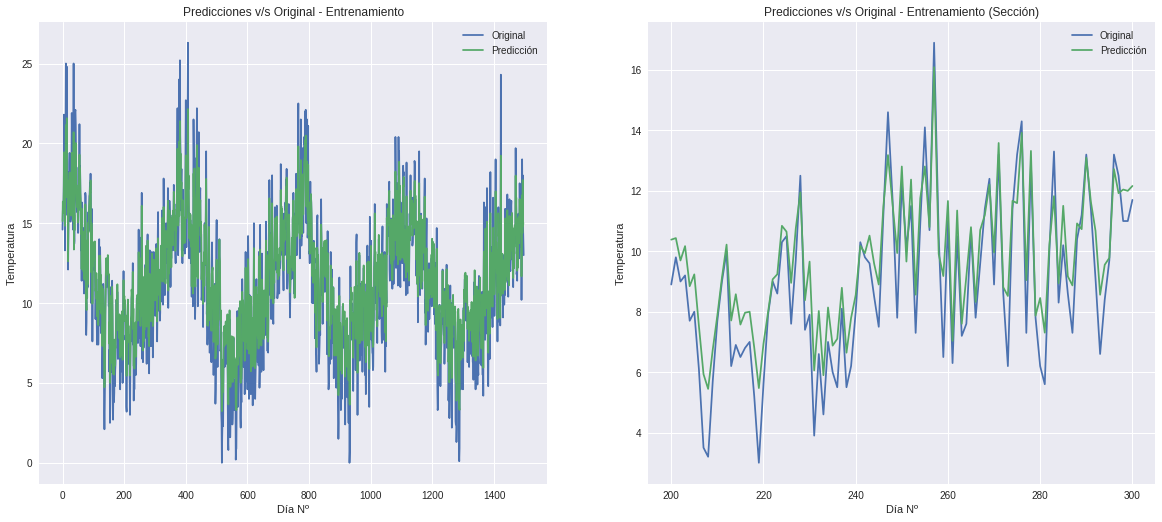

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))

ax1.plot(range(len(trainY)), trainY, trainPredictPlot)
ax1.set_title("Predicciones v/s Original - Entrenamiento")
ax1.legend(['Original', 'Predicción'], loc='upper right')
ax1.set_ylabel('Temperatura')
ax1.set_xlabel('Día Nº')

ax2.plot(range(200,301), trainY[200:301])
ax2.plot(range(200,301), trainPredictPlot[200:301])
ax2.set_title("Predicciones v/s Original - Entrenamiento (Sección)")
ax2.legend(['Original', 'Predicción'], loc='upper right')
ax2.set_ylabel('Temperatura')
ax2.set_xlabel('Día Nº')

plt.show()

Tal como pudimos concluir en el punto i, el gráfico de las temperaturas obtenidas mediante predicción y las temperaturas originales no muestran mayores diferencias con lo que se presentó en el punto antes mencionado, mostrando una curva de temperaturas predichas que se asemeja bastante a la curva original, además de no contar la historia completa respecto al desempeño de la red, como pudimos apreciar anteriormente mediante el análisis de los tiempos de ejecución de ambas redes.

**Parte p)**

De todas las redes estudiadas en este informe, las 2 redes que lograron el mejor desempeño fueron la red LSTM del punto e) utilizando un lag de 4, y la red SimpleRNN estudiada en el punto l). Para esta pregunta, entonces, utilizaremos una red LSTM con un lag de 4, trabajando sobre un conjunto de 4 datos iniciales, y progresivamente utilizando datos de las predicciones realizadas por la red para realizar predicciones futuras.

In [79]:
lag = 4
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(LSTM(units=4, input_shape=(None, lag), activation='tanh', recurrent_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
inicio = timer()
hist = model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=2)
end = timer()

Epoch 1/25
 - 11s - loss: 0.0164
Epoch 2/25
 - 10s - loss: 0.0111
Epoch 3/25
 - 10s - loss: 0.0107
Epoch 4/25
 - 10s - loss: 0.0105
Epoch 5/25
 - 10s - loss: 0.0103
Epoch 6/25
 - 10s - loss: 0.0102
Epoch 7/25
 - 10s - loss: 0.0102
Epoch 8/25
 - 11s - loss: 0.0101
Epoch 9/25
 - 10s - loss: 0.0101
Epoch 10/25
 - 10s - loss: 0.0099
Epoch 11/25
 - 11s - loss: 0.0100
Epoch 12/25
 - 10s - loss: 0.0100
Epoch 13/25
 - 10s - loss: 0.0099
Epoch 14/25
 - 11s - loss: 0.0099
Epoch 15/25
 - 10s - loss: 0.0099
Epoch 16/25
 - 11s - loss: 0.0098
Epoch 17/25
 - 10s - loss: 0.0099
Epoch 18/25
 - 10s - loss: 0.0100
Epoch 19/25
 - 11s - loss: 0.0098
Epoch 20/25
 - 11s - loss: 0.0098
Epoch 21/25
 - 11s - loss: 0.0097
Epoch 22/25
 - 10s - loss: 0.0099
Epoch 23/25
 - 10s - loss: 0.0098
Epoch 24/25
 - 10s - loss: 0.0099
Epoch 25/25
 - 10s - loss: 0.0099


Ahora, realizamos las predicciones sucesivas en base a predicciones anteriores, que es lo que especifica el enunciado de este punto. Comenzaremos con los primeros 4 datos del set de pruebas, e iremos moviendo la "ventana" de la cual extraeremos los datos para realizar la predicción a medida que las realizamos.

In [0]:
#Definimos nuestro arreglo donde guardaremos nuestras predicciones...
predicciones = []
#Y lo inicializamos a los primeros 4 valores del set de pruebas (es decir, el primer elemento de testX)
predicciones[:4] = testX[0][0]

#Para poder usar los datos del arreglo de predicciones con model.predict,
#creamos un arreglo de numpy con la dimensionalidad requerida por la red para poder
#realizar las predicciones (en este caso, un arreglo de 3 dimensiones, pero de sólo 1 elemento)
curr_data = np.empty(shape=(1, testX[0].shape[0], testX[0].shape[1]))
#Los límites inferior y superior de nuestra ventana, que definirán la porción de los
#datos del arreglo de predicciones a utilizar en la predicción por la red.
lim_inf = 0
lim_sup = 4

while len(predicciones) < len(testY):
    #Copiamos los datos de la ventana al arreglo de numoy
    curr_data[0][0] = predicciones[lim_inf:lim_sup]
    #Hacemos la predicción
    pred = model.predict(curr_data, batch_size = 1)
    #Y agregamos el nuevo valor obtenido de la predicción al arreglo
    predicciones.append(pred[0][0])
    #Desplazamos en una unidad nuestra ventana, para que la siguiente preducción
    #utilice el nuevo valor que acabamos de obtener
    lim_inf += 1
    lim_sup += 1

Para observar las curvas de temperatura originales y obtenida mediante predicciones sucesivas, realizamos el procedimiento que hemos realizado en puntos anteriores para poder graficar estas curvas.

In [0]:
testY = scaler.inverse_transform(testY)
predicciones = scaler.inverse_transform(np.array(predicciones).reshape(-1, 1))

In [0]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[0:len(predicciones)-1, :] = predicciones[1:]

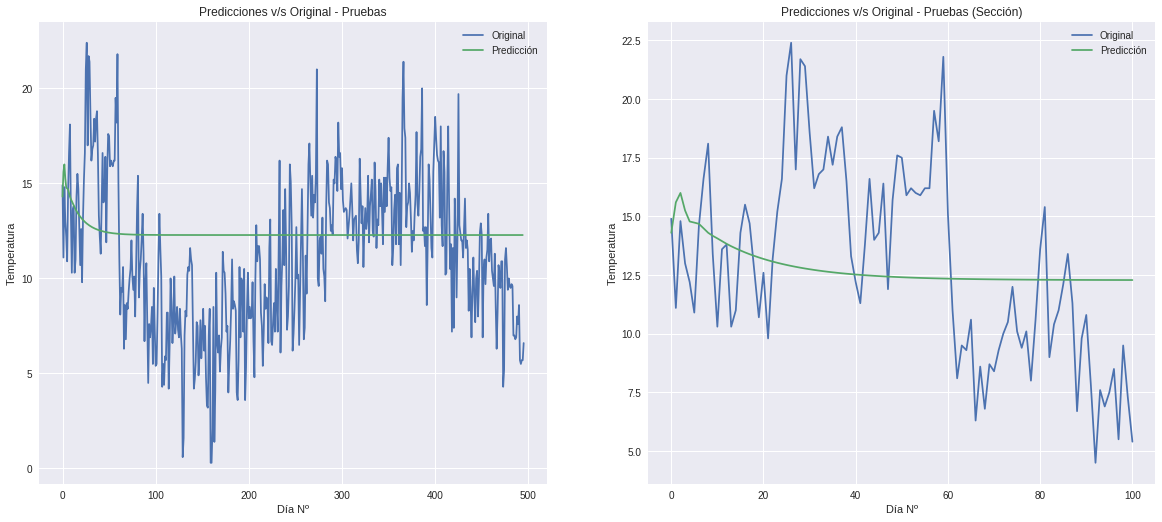

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.5))

ax1.plot(range(len(testY)), testY, testPredictPlot)
ax1.set_title("Predicciones v/s Original - Pruebas")
ax1.legend(['Original', 'Predicción'], loc='upper right')
ax1.set_ylabel('Temperatura')
ax1.set_xlabel('Día Nº')

ax2.plot(range(0,101), testY[0:101])
ax2.plot(range(0,101), testPredictPlot[0:101])
ax2.set_title("Predicciones v/s Original - Pruebas (Sección)")
ax2.legend(['Original', 'Predicción'], loc='upper right')
ax2.set_ylabel('Temperatura')
ax2.set_xlabel('Día Nº')

plt.show()

El comportamiento que podemos observar aquí es bastante interesante, dado que es algo que no habíamos visto antes que sucediera con una red neuronal. En los primeros epochs (que, consecuentemente, corresponden a los epochs en donde se encontraban datos del set de prueba), se puede observar que la red aparentemente está realizando predicciones que podrían tener algún sentido, aún cuando se puede observar que la predicción realizada se escapa de lo que se puede observar en la curva original en el mismo intervalo de epochs. Sin embargo, y a partir del momento en que la red comienza a realizar predicciones en base a sus propias predicciones anteriores, observamos que los valores predichos parecen converger hacia un valor específico, que en este caso es de 12.28. Esto guarda muchas similitudes a lo que podríamos esperar de métodos de cálculo utilizados en Computación Científica, en donde un método itera sobre un espacio de valores encontrando el mínimo o máximo de una función específica. Todo esto nos dice que la red no es capaz de operar únicamente en base a valores obtenidos por la predicción de la misma red, y que es necesario contar con datos de nuestro problema para poder realizar predicciones adecuadas.